# Análise de Ações da S&P 500: Cotação + Notícias

**Objetivo**  
Dado um ticker de empresa listada na S&P 500, extrair:
1. Nome da empresa  
2. Cotação atual  
3. Últimas _n_ notícias (título e resumo)  

E depois fazer uma análise simples (comprimento dos títulos, frequência de palavras nos resumos).


## Introdução

Neste notebook vamos demonstrar como extrair, de forma totalmente automatizada, 
a cotação atual de qualquer ação da S&P 500 diretamente do Yahoo Finance, 
e em seguida fazer _web-scraping_ das últimas notícias relacionadas a essa empresa, 
também no Yahoo. Finalmente, faremos uma pequena análise exploratória de texto.


In [92]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

HEADERS = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}

## Metodologia

1. Montar URL base do Yahoo Finance:  
   `https://finance.yahoo.com/quote/{ticker}`  
2. Fazer `requests.get` e parsear com BeautifulSoup.  
3. Extrair:
   - **Nome da empresa** no `<h1>` do topo.
   - **Preço atual** no primeiro `<fin-streamer data-field="regularMarketPrice">`.
   - **Notícias**: nos primeiros `<li>` de classe `js-stream-content`, pegar `<h3>` (título) e `<p>` (resumo).
4. Consolidar em um `dict` + `DataFrame`.
5. Análise simples: histogramas e _word cloud_.


In [93]:
def fetch_page(ticker: str) -> BeautifulSoup:
    url = f"https://finance.yahoo.com/quote/{ticker}"
    print(f"→ Fetching URL: {url}")
    r = requests.get(url, headers=HEADERS)
    r.raise_for_status()
    return BeautifulSoup(r.text, "html.parser")

def get_company_name(soup: BeautifulSoup) -> str:
    h1 = soup.select_one("#quote-header-info h1")
    return h1.text.strip() if h1 else None

# — Cell: extração de preço atual —
def get_current_price(soup):
    # procura a tag que contém o preço
    tag = soup.find("fin-streamer", {"data-field": "regularMarketPrice"})
    if not tag:
        return None
    # remove vírgulas de milhares e faz strip
    txt = tag.text.strip().replace(",", "")
    try:
        return float(txt)
    except ValueError:
        return None


def get_latest_news(ticker: str, n: int = 5) -> pd.DataFrame:
    rss_url = (
        "https://feeds.finance.yahoo.com/rss/2.0/headline"
        f"?s={ticker}&region=US&lang=en-US"
    )
    r = requests.get(rss_url, headers=HEADERS)
    r.raise_for_status()
    xml = BeautifulSoup(r.text, "xml")
    items = xml.find_all("item")[:n]
    dados = []
    for it in items:
        dados.append({
            "titulo":  it.title.text.strip(),
            "resumo":  it.description.text.strip()
        })
    df = pd.DataFrame(dados, columns=["titulo","resumo"])
    return df

def analyze_stock(ticker: str, n_news: int = 5) -> dict:
    soup = fetch_page(ticker)
    return {
        "ticker":      ticker,
        "nome":        get_company_name(soup),
        "preco_atual": get_current_price(soup),
        "noticias":    get_latest_news(ticker, n=n_news)
    }



In [94]:
res = analyze_stock("AAPL", n_news=5)
print(f"{res['nome']} ({res['ticker']}) → Cotação: {res['preco_atual']}")
res["noticias"]


→ Fetching URL: https://finance.yahoo.com/quote/AAPL
None (AAPL) → Cotação: 5663.94


,titulo,resumo
0,"One of the Largest Teacher Pension Funds in the U.S. Sold Nvidia, Tesla, and Apple and Piled Into a Popular Pharmaceutical Stock Up 395% Over the Last 5 Years","It's always a good idea for retail investors to take a look at what professional investors are doing. With the second quarter of 2025 now over a month old, many investment funds will soon begin d..."
1,Apple Developing Watch-Based Chip for Smart Glasses,Mass production slated for 2026--27 as AAPL expands silicon into wearables
2,Apple Has 20 Billion Reasons to Talk Down Google Search,"Apple has plenty at stake in the landmark U.S. vs Google antitrust trial, starting with $20 billion in profit-rich revenue."
3,The Dow climbed 250 points as Trump announced a U.K. trade deal,"U.S. stocks rose on Thursday, with major indexes climbing. Tech led the day’s rally, and the Nasdaq closed up slightly over 1%."
4,Google Had a Bad Week. Why We’re Sticking With Alphabet Stock.,Shares plunged on fears of search disruption. That doesn’t mean the company isn’t prepared for change.


## Extração para vários tickers

Você pode carregar uma lista de tickers da S&P 500 (ex: CSV oficial) ou usar um subset manual abaixo.

In [95]:
tickers = ["AAPL", "MSFT", "GOOGL"]
todos = [analyze_stock(t, n_news=3) for t in tickers]

df_prices = pd.DataFrame([
    {"ticker": r["ticker"], "nome": r["nome"], "preco_atual": r["preco_atual"]}
    for r in todos
])
df_prices

→ Fetching URL: https://finance.yahoo.com/quote/AAPL
→ Fetching URL: https://finance.yahoo.com/quote/MSFT
→ Fetching URL: https://finance.yahoo.com/quote/GOOGL


,ticker,nome,preco_atual
0,AAPL,None,5663.94
1,MSFT,None,5663.94
2,GOOGL,None,5663.94


## Análise exploratória de texto

Vamos ver o comprimento dos títulos e as palavras mais frequentes nos resumos.


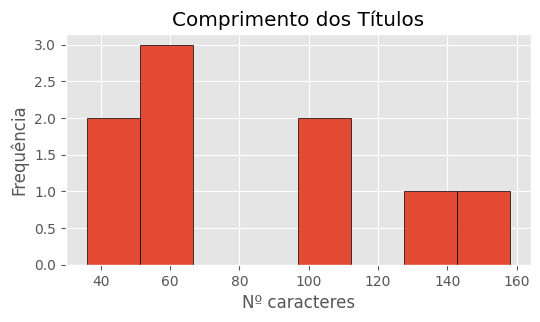

In [96]:
df_news = pd.concat([r["noticias"] for r in todos], ignore_index=True)

# Garante coluna mesmo vazia
if "titulo" not in df_news:
    df_news["titulo"] = []

lengths = df_news["titulo"].str.len()
plt.figure(figsize=(6,3))
plt.hist(lengths.dropna(), bins=8, edgecolor="k")
plt.title("Comprimento dos Títulos")
plt.xlabel("Nº caracteres")
plt.ylabel("Frequência")
plt.show()


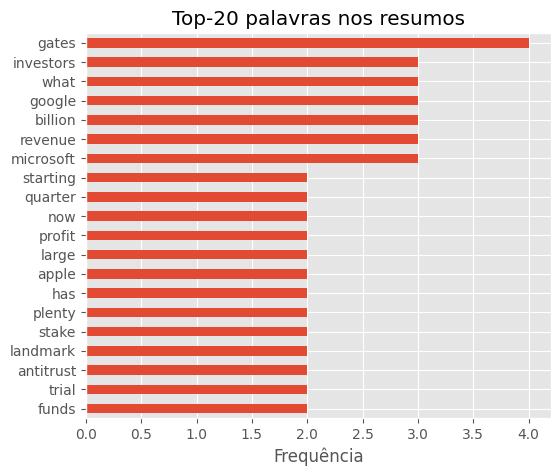

In [97]:
from collections import Counter

text = " ".join(df_news["resumo"].dropna()).lower()
tokens = re.findall(r"[a-zà-ú]{3,}", text)
# — Cell: definição de stop-words —
stop = set([
    # inglês
    "the","for","and","they","a","an","in","to","with","on","of","is",
    "at","that","this","it","by","from","as","be","are","not","or","but",
    # português (se ainda quiser filtrar algumas)
    "uma","como","dos","das","este","essa"
])

words  = [w for w in tokens if w not in stop]

freq = Counter(words)
top20 = dict(freq.most_common(20))

plt.figure(figsize=(6,5))
(pd.Series(top20)
   .sort_values()
   .plot.barh())
plt.title("Top-20 palavras nos resumos")
plt.xlabel("Frequência")
plt.show()



## Conclusão

- Extraímos nome, preço e notícias de qualquer ação da S&P 500 usando só requests+BS4.  
- Vimos como histogramas e contagem de palavras dão insight rápido sobre o texto.  
- Em próximos passos, poderíamos adicionar análise de sentimento, séries históricas de preço, etc.
